# Dose-Response Curves

25th Apr
This notebook is for plotting custom dose-response curves.

In [2]:
import pandas as pd

df_mpro = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/mpro_hits.csv').dropna(thresh=6)
df_grouped_by_mol = df_mpro.groupby('Canonical PostEra ID')
for mol, df in df_grouped_by_mol:
    print(mol, df)


ALP-UNI-ed5cdfd2-1     Molecule Name Structure CDD Number  \
168   CVD-0020426                  NaN   
169   CVD-0020426                  NaN   
170   CVD-0020426                  NaN   
171   CVD-0020426                  NaN   
172   CVD-0020426                  NaN   
173   CVD-0020426                  NaN   
174   CVD-0020426                  NaN   
175   CVD-0020426                  NaN   
176   CVD-0020426                  NaN   
177   CVD-0020426                  NaN   
178   CVD-0020426                  NaN   
179   CVD-0020426                  NaN   
180   CVD-0020426                  NaN   
181   CVD-0020426                  NaN   
182   CVD-0020426                  NaN   
183   CVD-0020426                  NaN   
184   CVD-0020426                  NaN   
185   CVD-0020426                  NaN   
186   CVD-0020426                  NaN   
187   CVD-0020426                  NaN   
188   CVD-0020426                  NaN   
189   CVD-0020426                  NaN   
190   CVD-00204

Do Dose-Response Fit

In [3]:
import numpy as np
import scipy.optimize as opt


def logistic_4_param(x, b, e):
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - e: EC50'''
    return 100.0/(1+np.exp(b*(np.log(x)-np.log(e))))

def return_fit(x, y, log=False):
    try:
        best_fit_coefs, _ = opt.curve_fit(logistic_4_param, x, y, p0=[1, 100])
    except RuntimeError or ValueError:
        return None
    interp_x = np.linspace(min(x)*0.9, max(x)*1.1, 1024)
    interp_y = logistic_4_param(interp_x, *best_fit_coefs)
    fitted_ic50 = best_fit_coefs[-1]
    if log:
        print(f'The found IC50 is : {best_fit_coefs[-1]:.3f}uM')
    return (interp_x, interp_y, fitted_ic50)


Do the plotting

/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


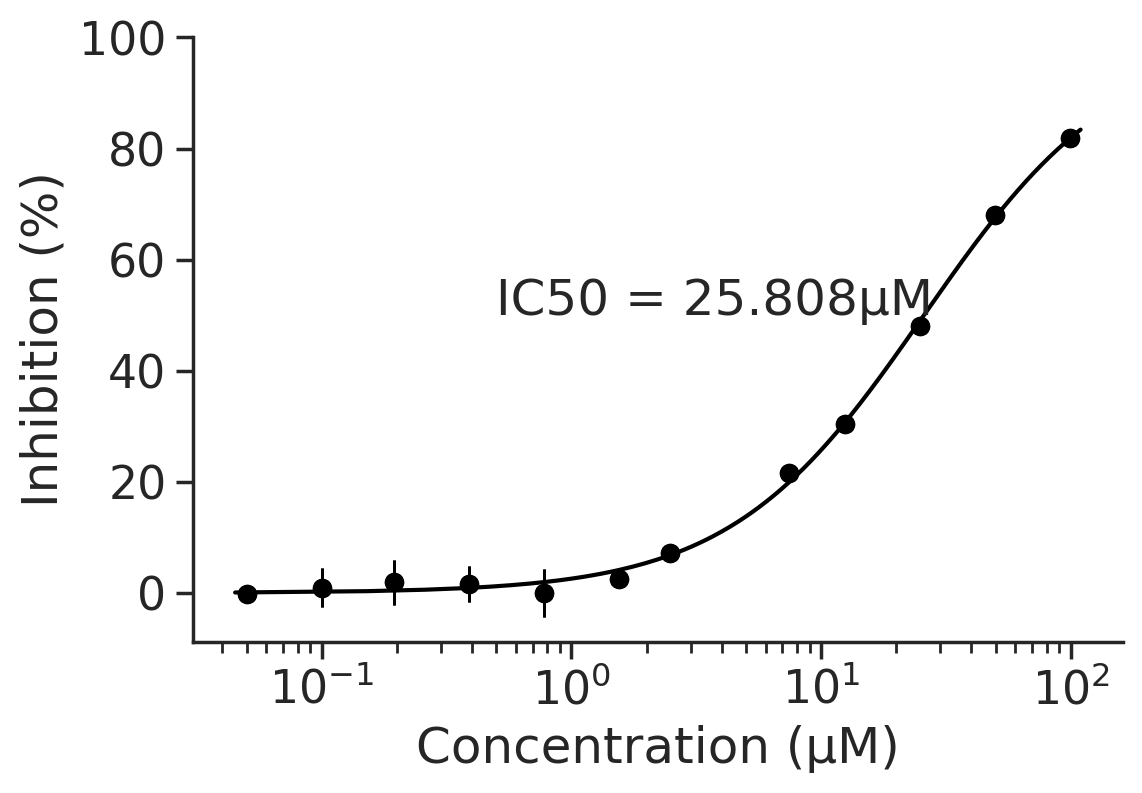

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams["font.family"] = u"Helvetica"
# plt.rcParams['xtick.labelsize'] = 18 
# plt.rcParams['ytick.labelsize'] = 18 
# plt.rcParams['xlabel.fontsize'] = 18 
# plt.rcParams['ylabel.fontsize'] = 18 


def make_dose_response_plot(mol_id : str ='WIL-UNI-d4749f31-37', plot_IC50=True, color='#0066FF'):
    
    fig = plt.figure(dpi=200)
    ax = plt.gca()

    df_mol = df_grouped_by_mol.get_group(mol_id).dropna(axis='columns').copy()
    df_mol = df_mol.rename(
        columns={'ProteaseAssay_Fluorescence_Dose-Response_Weizmann: Concentration (µM)': 'Concentration (µM)',
                 'ProteaseAssay_Fluorescence_Dose-Response_Weizmann: Inhibition (%)': 'Inhibition (%)'})
    if len(df_mol) == 1:
        print(f'No data for molecule {mol_id}')
        return
    x = df_mol['Concentration (µM)']
    y = df_mol.groupby('Concentration (µM)')[
        'Inhibition (%)'].transform('mean')
    df_mol['sd'] = df_mol.groupby('Concentration (µM)')[
        'Inhibition (%)'].transform('std')

    ax.errorbar(x, 
                y, 
                yerr=df_mol['sd'], 
                fmt='.', 
                markersize=12,
                capsize=None,
                elinewidth=1,
                color=color)

    fit = return_fit(x, y)
    if fit is not None and max(y)>10:
        fitted_x, fitted_y, fitted_ic50 = fit 
        df_fitted = pd.DataFrame({'Concentration (µM)': fitted_x,
                        'Inhibition (%)': fitted_y})
        sns.lineplot(data=df_fitted,
                    x='Concentration (µM)',
                    y='Inhibition (%)',
                    color=color,
                    ax=ax)
        if plot_IC50:
            
            plt.text(0.5, 50, f'IC50 = {fitted_ic50:.3f}µM',)
            # plt.text(fitted_ic50, 0.5, f'IC50 = {fitted_ic50:.3f}µM',)
            
    else:
        ax.set_xlabel('Concentration (µM)')
        ax.set_ylabel('Inhibition (%)')
    sns.despine()
    ax.set_xscale('log')
    ax.set_ylim(top=100)
    # fig.suptitle(f'Dose-Response Curve for {mol_id}')
    fig.show()
    return

make_dose_response_plot(color='black')


/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


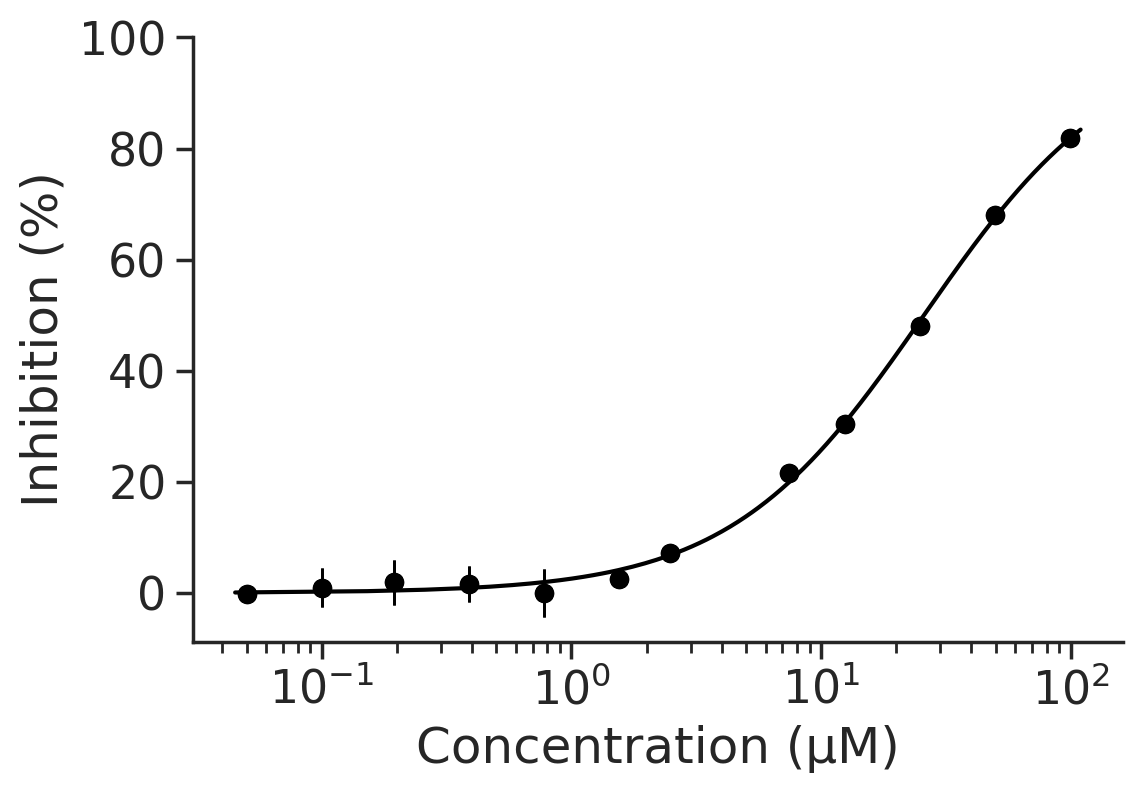

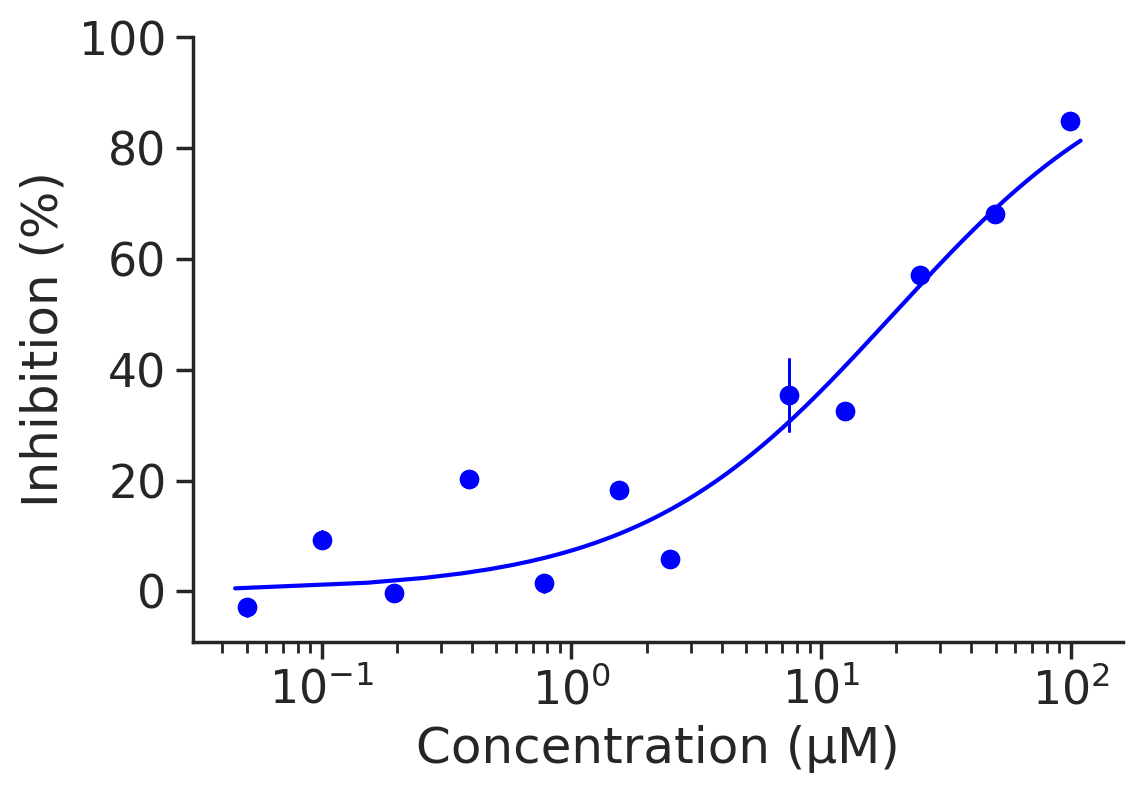

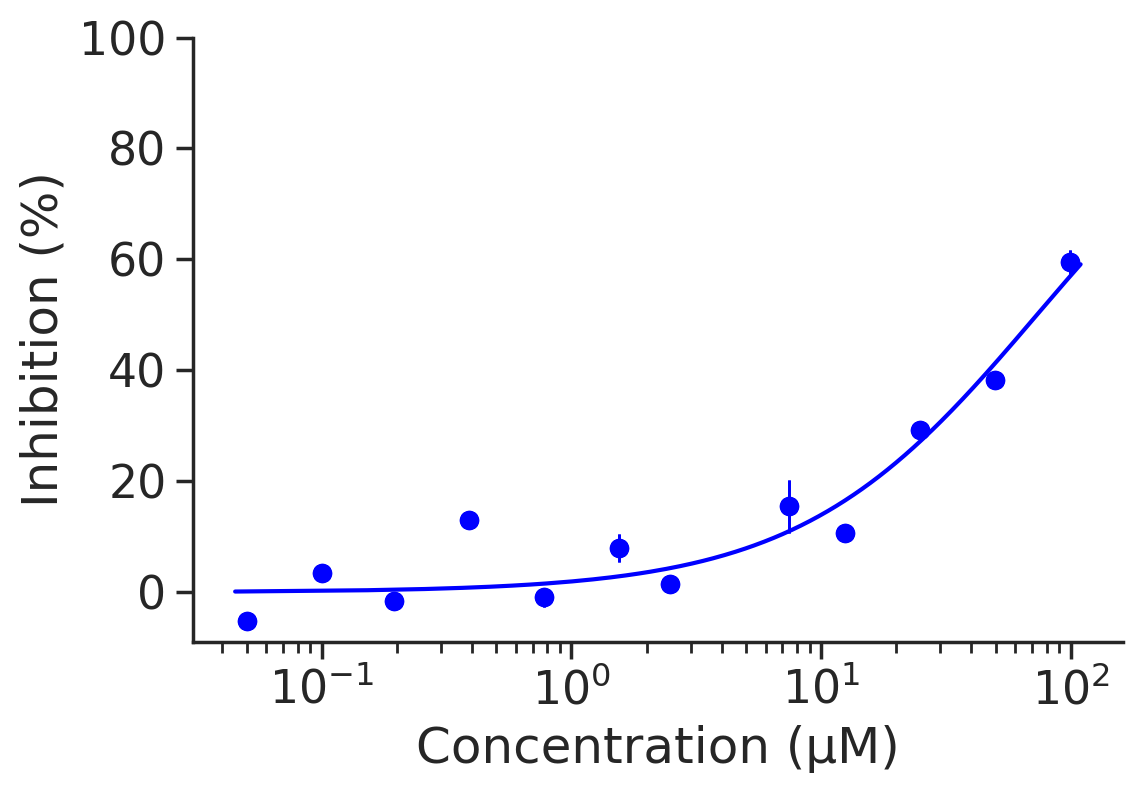

In [27]:
active_mols = ['WIL-UNI-d4749f31-37',
               'ALP-UNI-ed5cdfd2-1',
               'ALP-UNI-ed5cdfd2-3']

list_of_colors = ['black', '#0000FF', '#0000FF']

for color, mol in zip(list_of_colors, active_mols):
    make_dose_response_plot(mol, plot_IC50=False, color=color)

Plot Dose-Response for multiple mols

In [30]:
def multiple_plots(list_of_mol_ids, color_list = None):
    fig = plt.figure(dpi=200)
    ax = plt.gca()

    if color_list is None:
        color_palette = sns.color_palette('tab10')
    else:
        color_palette = color_list
    for index, mol_id in enumerate(list_of_mol_ids):
        current_color = color_palette[index]
        df_mol = df_grouped_by_mol.get_group(mol_id).dropna(axis='columns').copy()
        df_mol = df_mol.rename(
            columns={'ProteaseAssay_Fluorescence_Dose-Response_Weizmann: Concentration (µM)': 'Concentration (µM)',
                    'ProteaseAssay_Fluorescence_Dose-Response_Weizmann: Inhibition (%)': 'Inhibition (%)'})
        if len(df_mol) == 1:
            print(f'No data for molecule {mol_id}')
            return
        x = df_mol['Concentration (µM)']
        y = df_mol.groupby('Concentration (µM)')[
            'Inhibition (%)'].transform('mean')
        df_mol['sd'] = df_mol.groupby('Concentration (µM)')[
            'Inhibition (%)'].transform('std')

        ax.errorbar(x, 
                    y, 
                    yerr=df_mol['sd'], 
                    fmt='.', 
                    markersize=8,
                    color=current_color)

        fit = return_fit(x, y, log=True)
        if fit is not None and max(y)>10:
            fitted_x, fitted_y, fitted_ic50 = fit 
            df_fitted = pd.DataFrame({'Concentration (µM)': fitted_x,
                            'Inhibition (%)': fitted_y})
            sns.lineplot(data=df_fitted,
                        x='Concentration (µM)',
                        y='Inhibition (%)',
                        label=mol_id,
                        color=current_color,
                        ax=ax)
            
        else:
            ax.set_xlabel('Concentration (µM)')
            ax.set_ylabel('Inhibition (%)')
    sns.despine()
    ax.set_xscale('log')
    ax.set_ylim(top=100)
    ax.set_title(f'Dose-Response Curve for inactive mols')
    plt.legend(frameon=False)
    fig.show()
    return


/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


The found IC50 is : 108.419uM
The found IC50 is : 153.653uM
The found IC50 is : 388.795uM
The found IC50 is : 130.200uM
The found IC50 is : 266.023uM


/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


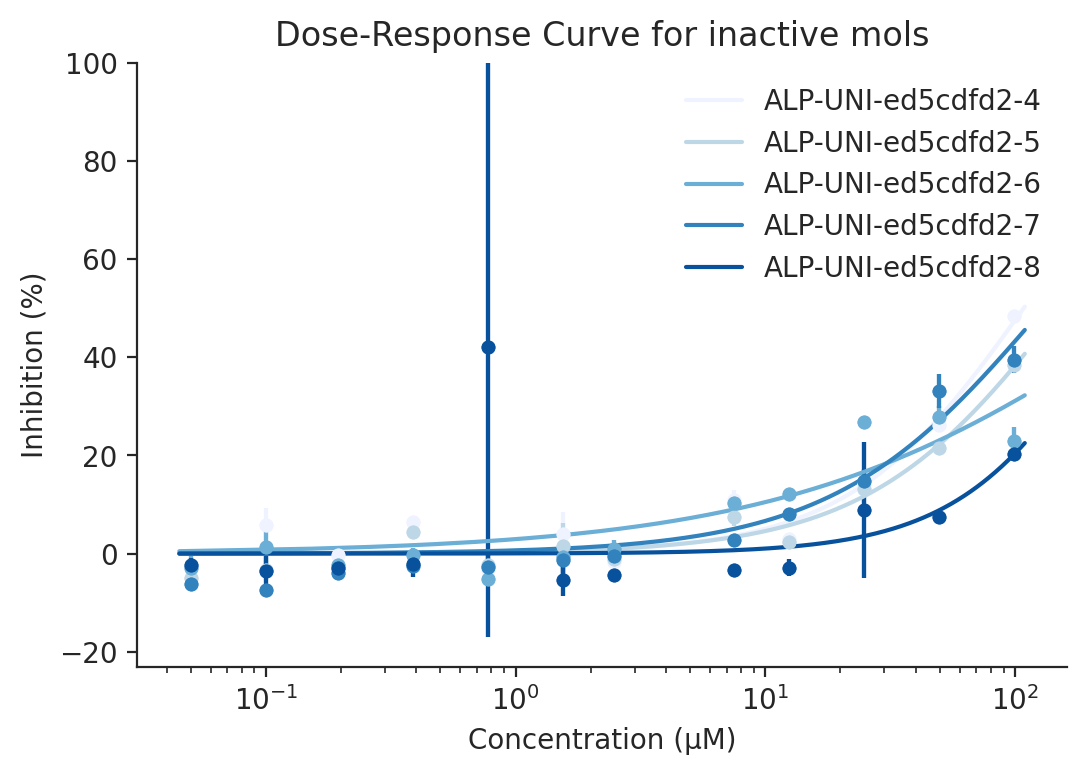

In [31]:
inactive_mols = ['ALP-UNI-ed5cdfd2-4',
                 'ALP-UNI-ed5cdfd2-5',
                 'ALP-UNI-ed5cdfd2-6',
                 'ALP-UNI-ed5cdfd2-7',
                 'ALP-UNI-ed5cdfd2-8',
                 ]
list_of_colors = ['#eff3ff',
                  '#bdd7e7',
                  '#6baed6',
                  '#3182bd',
                  '#08519c',
                  ]
multiple_plots(inactive_mols, color_list=list_of_colors)


30th Apr - received inhibition data from Marion, plotting for Z5551425673.

In [8]:
df_mac1_hit = pd.read_csv('/home/wjm41/ml_physics/frag-pcore-screen/data/Mac1/Z5551425673_inhibition.csv')
x = df_mac1_hit['Concentration (uM)']
y = df_mac1_hit[['Inhibition1 (%)', 'Inhibition2 (%)']].mean(axis=1)
std = df_mac1_hit[['Inhibition1 (%)', 'Inhibition2 (%)']].std(axis=1)

/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


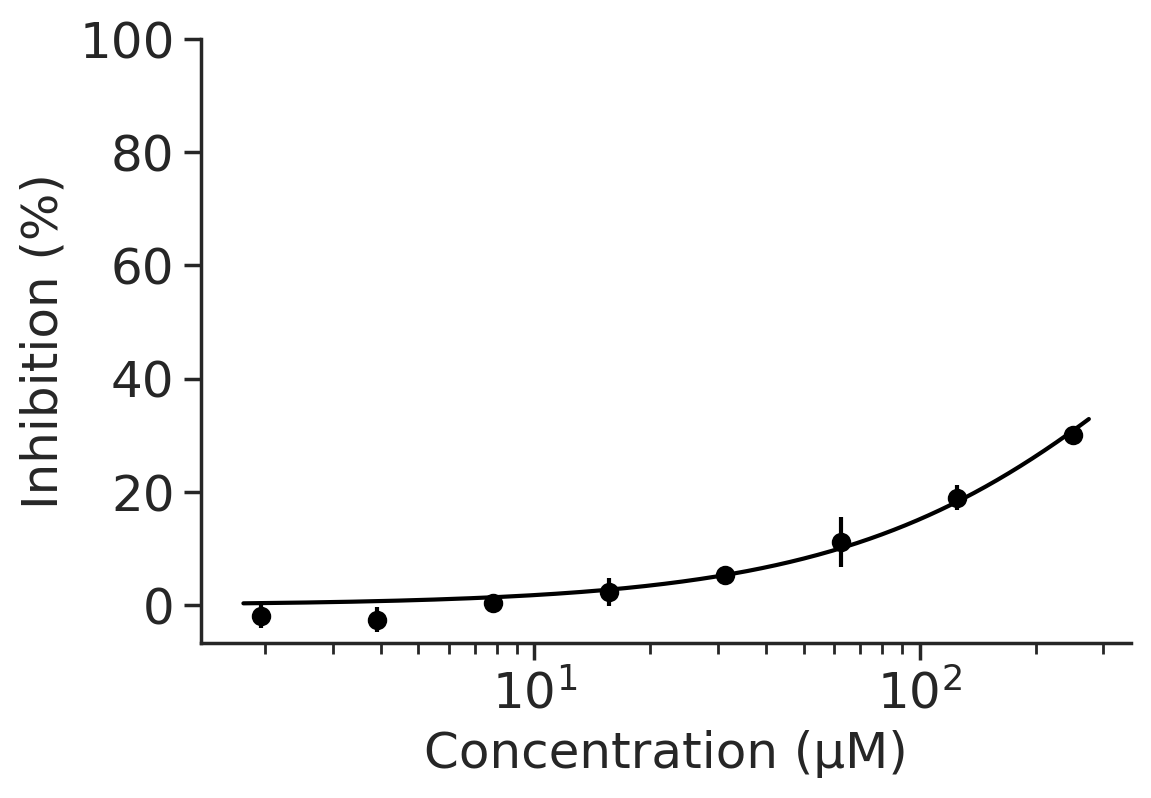

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)
sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams["font.family"] = u"Helvetica"

fig = plt.figure(dpi=200)
ax = plt.gca()

ax.errorbar(x,
            y,
            yerr=std,
            fmt='.',
            markersize=12,
            color='black')

fit = return_fit(x, y)
if fit is not None and max(y) > 10:
    fitted_x, fitted_y, fitted_ic50 = fit
    df_fitted = pd.DataFrame({'Concentration (µM)': fitted_x,
                                'Inhibition (%)': fitted_y})
    sns.lineplot(data=df_fitted,
                    x='Concentration (µM)',
                    y='Inhibition (%)',
                    color='black',
                    ax=ax)
    # if plot_IC50:

    #     plt.text(0.5, 50, f'IC50 = {fitted_ic50:.3f}µM',)
        # plt.text(fitted_ic50, 0.5, f'IC50 = {fitted_ic50:.3f}µM',)

# else:
#     ax.set_xlabel('Concentration (µM)')
#     ax.set_ylabel('Inhibition (%)')
sns.despine()
ax.set_xscale('log')
ax.set_ylim(top=100)
# ax.set_title(f'Dose-Response Curve for Z5551425673')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fig.show()

